## Intro

## Spline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interp

def f(x, y):
    return -np.exp(-(y-np.sin(x))**2)

x = np.linspace(-3, 3, 500)
y = np.linspace(-3, 3, 500)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

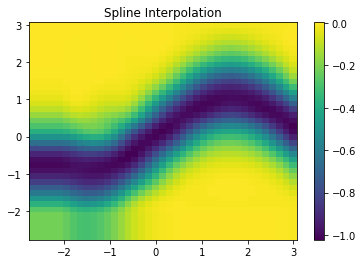

In [3]:
x_edges, y_edges = np.mgrid[-3:3:11j, -3:3:11j]
x = x_edges[:-1, :-1] + np.diff(x_edges[:2, 0])[0]*1.5
y = y_edges[:-1, :-1] + np.diff(y_edges[0, :2])[0] *1.5
z = f(x,y)
xnew_edges, ynew_edges = np.mgrid[-3:3:41j, -3:3:41j]
xnew = xnew_edges[:-1, :-1] + np.diff(xnew_edges[:2, 0])[0] *1.5
ynew = ynew_edges[:-1, :-1] + np.diff(ynew_edges[0, :2])[0] *1.5
tck = interp.bisplrep(x, y, z, s=0)
znew = interp.bisplev(xnew[:,0], ynew[0,:], tck)
plt.pcolormesh(xnew, ynew, znew, shading='auto')
plt.title('Spline Interpolation')
plt.colorbar()
plt.show()

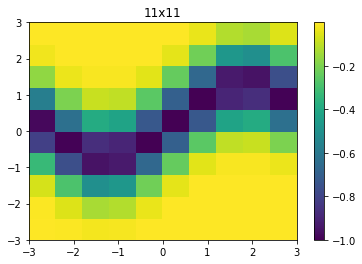

In [4]:
z_test = np.zeros((11, 11))
for i in range(11):
    for j in range(11):
        z_test[i][j] = f(x_edges[i][j], y_edges[i][j])
        

# test_arr = np.asarray([[1,2,3],[4,5,6],[7,8,9]])

def instantiate(arr2da, arr2db):
    for i in range(len(arr2da)):
        for j in range(len(arr2da[0])):
            arr2db[i*2][j*2] = arr2da[i][j]
    return arr2db
        
def increase_density(arr2d):
    sizeX = len(arr2d)
    sizeY = len(arr2d[0])
    newX = (sizeX-1)*2 + 1
    newY = (sizeY-1)*2 + 1
    arr2d_dense = np.zeros((newX, newY))
    arr2d_dense = instantiate(arr2d, arr2d_dense)
    
    for i in range(sizeX - 1):
        for j in range(sizeY - 1):
            arr2d_dense[i*2 + 1][j*2] = (arr2d_dense[i*2][j*2] + arr2d_dense[(i+1)*2][j*2])/2
            arr2d_dense[i*2][j*2 + 1] = (arr2d_dense[i*2][j*2] + arr2d_dense[i*2][(j+1)*2])/2
            
#     final row (on bottom) of matrix
    for i in range(sizeX - 1):
        arr2d_dense[i*2 + 1][newY-1] = (arr2d_dense[i*2][newY-1] + arr2d_dense[i*2 + 2][newY-1])/2
#     final column (on far-right side) of matrix
    for j in range(sizeY - 1):
        arr2d_dense[newX-1][j*2 + 1] = (arr2d_dense[newX-1][j*2] + arr2d_dense[newX-1][j*2 + 2])/2

#     centers of localized expansion
    for i in range(sizeX - 1):
        for j in range(sizeY - 1):
            arr2d_dense[i*2 + 1][j*2 + 1] = (arr2d_dense[i*2][j*2] + arr2d_dense[i*2+1][j*2] + arr2d_dense[i*2 + 2][j*2] + arr2d_dense[i*2][j*2 + 1] + arr2d_dense[i*2 + 2][j*2 + 1] + arr2d_dense[i*2][j*2 + 2] + arr2d_dense[i*2 + 1][j*2 + 2] + arr2d_dense[i*2 + 2][j*2 + 2])/8
    
    return arr2d_dense
        
plt.pcolormesh(x_edges, y_edges, z_test)
plt.colorbar()
plt.title('11x11')
plt.show()

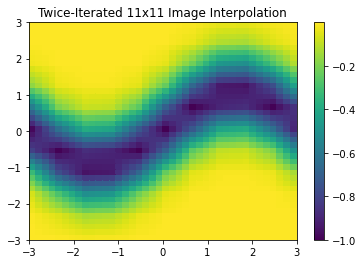

In [5]:
a = increase_density(x_edges)
b = increase_density(y_edges)
c = increase_density(z_test)
z_naivedense = increase_density(c)

plt.pcolormesh(xnew_edges, ynew_edges, z_naivedense)
plt.colorbar()
plt.title('Twice-Iterated 11x11 Image Interpolation')
plt.show()

In [6]:
x = np.linspace(-3, 3, 41)
y = np.linspace(-3, 3, 41)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

# I throw out the last row and column because not all these matrices are exactly the same size
# I also throw out the first sqrt(m) columns because of the error in the spline method discussed above
mag = 0
obs_mag_spline = 0
obs_mag_jank = 0
i = 7
while(i < len(Z)-1):
    for j in range(len(Z[0])-1):
        mag += Z[i][j]
        obs_mag_spline += znew[i][j]
        obs_mag_jank += z_naivedense[i][j]
    i += 1
        
spline_error = np.abs((obs_mag_spline-mag)/mag)
jank_error = np.abs((obs_mag_jank-mag)/mag)
print("Spline error for 10x10: ", spline_error)
print("Averaging error for 10x10: ", jank_error)

Spline error for 10x10:  0.14669096333622791
Averaging error for 10x10:  0.16053158342040574


Both of these methods have notable drawbacks, in that the input data needs to be well-organized and relatively complete. It will not work like some interpolation methods that allow for randomly selected datapoints from all over the surface of a function. 

Overall, Spline interpolation (with the exception of the first 7ish columns of each output) marginally outperformed a crude and naive averaging function, which is to be expected for a sample curve such as the one used for this project. Given a more complex curve that has rapid topology fluxuations, I would expect the naive approach to underperform, while the spline approach would work comparitively better. This is because the spline interpolation method does not just take the values of the points given, but also takes into account the derivative, second derivative, and even third derivative in order to more accurately compute unknown values.

The advantages of the spline approach is that with a relatively complete dataset, one can more accurately account for fluxuations on a surface than a variety of other methods.
However, the drawbacks of the spline approach are arguably even more clear: It requires much more well-organized input data that if gathered in practice would be much more time and resource intensive.

## Inverse Distance Weighting (IDW)

In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from photutils.utils import ShepardIDWInterpolator as idw

# synthetic example
def f(x, y):
    return -np.exp(-(y-np.sin(x))**2)

# create ground truth grid
x = np.linspace(-3, 3, 500)
y = np.linspace(-3, 3, 500)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

IDW interpolation is based on the assumption that things that are close to each other are more alike than those far apart. This assumption is known as **spatial autocorrelation**. To predict an unknown value, IDW uses measured values surrounding it, having more weight on closer points than farther points. IDW uses a power p value to determine what weight to assign to that value based on distance. A high p value means only the immediate surrounding points will influence the prediction.

$$ \omega_i = \frac{1}{d(x, x_i)^{p} +r} $$
$x = $ interpolated point  
$x_i =$ known point  
$d = $ distance from known to unknown  
$p =$ power  
$r = $ regularization parameter  


![alt text](idw-graph.png "Title")

Advantages  
- Can estimate extreme changes (cliffs, fault lines)
- Dense evenly space points are well interpolated 

Disadvantages  
- Can't estimate above maximum or below minimum values 
- Sensitive to outliers
- Not very good for peaks or mountainous areas 

In [2]:
def run_IDW(n):
    x = np.linspace(-3, 3, 50000)
    y = np.linspace(-3, 3, 50000)
    sample_x = x[np.random.choice(len(x), size=n, replace=False)]
    sample_y = y[np.random.choice(len(y), size=n, replace=False)]
    sample_z = f(sample_x, sample_y)
    pos = np.vstack((sample_x, sample_y)).T
    f_predict = idw(pos, sample_z)
    inputx = np.linspace(-3, 3, 500)
    inputy = np.linspace(-3, 3, 500)
    X1, Y1 = np.meshgrid(inputx, inputy)
    Z1 = []
    for i in range(len(X1)):
        xrow = X1[i]
        yrow = Y1[i]
        row_grid = np.vstack((xrow, yrow)).T
        z_row = f_predict(row_grid)
        Z1.append(z_row)
    return Z1

def calculate_err(Z_predict):
    return np.linalg.norm(np.abs(np.subtract(Z, Z_predict)))

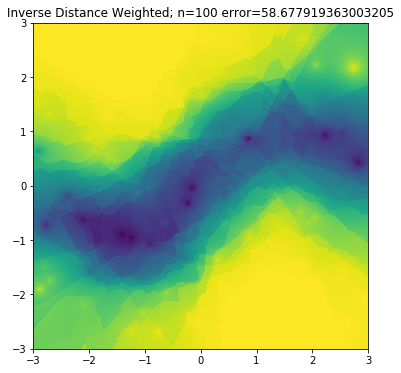

In [3]:
inputx = np.linspace(-3, 3, 500)
inputy = np.linspace(-3, 3, 500)
X1, Y1 = np.meshgrid(inputx, inputy)
Z_predict = run_IDW(100)
err = calculate_err(Z_predict)
plt.figure(figsize=(6,6))
plt.pcolormesh(X1, Y1, Z_predict, shading='auto')
plt.title(f'Inverse Distance Weighted; n=100 error={err}')
plt.show()

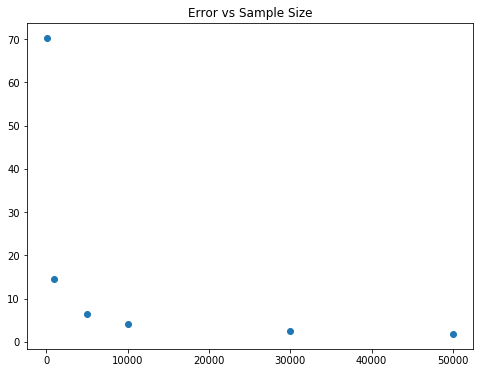

In [4]:
x = np.linspace(-3, 3, 50000)
y = np.linspace(-3, 3, 50000)
sample_sizes = [100, 1000, 5000, 10000, 30000, 50000]
errors = []
for size in sample_sizes:
    Z_predict = run_IDW(size)
    errors.append(calculate_err(Z_predict))
plt.figure(figsize=(8,6))
plt.scatter(sample_sizes, errors)
plt.title('Error vs Sample Size')
plt.show()

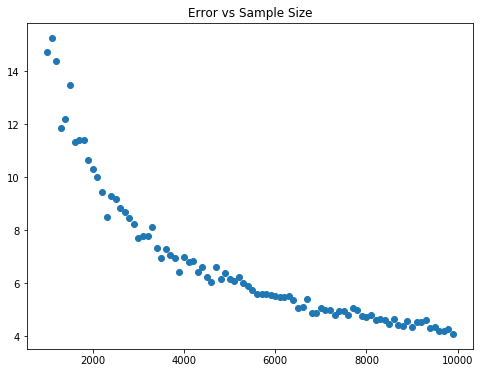

In [5]:
x = np.linspace(-3, 3, 50000)
y = np.linspace(-3, 3, 50000)
sample_sizes = np.arange(1000, 10000, 100)
errors2 = []
for size in sample_sizes:
    Z_predict = run_IDW(size)
    errors2.append(calculate_err(Z_predict))
plt.figure(figsize=(8,6))
plt.scatter(sample_sizes, errors2)
plt.title('Error vs Sample Size')
plt.show()

## Radial

## Kriging

## Direct Comparison

## Next Steps